# Analyzing Short Opportunities in Gold Price Surges

This analysis explores how uncommon rises in the Gold price (symbol: `GC=F`) could signal profitable short positions. The analysis considers the behavior of the 5-day percentage change in adjusted closing prices and identifies the points at which the percentage change exceeds a defined threshold. The strategy aims to enter short positions following these uncommon rises and exit when the market drops significantly. 

## Objectives:
- Identify uncommon rises based on a threshold.
- Simulate short positions by entering after a rise and exiting at the most profitable drop.
- Calculate key statistics to evaluate the effectiveness of the strategy.

## Data Collection

The data used for this analysis was downloaded from Yahoo Finance using the `yfinance` library. The dataset includes adjusted closing prices of the gold future contracts from January 1, 2001, to the present day.


In [111]:
# Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Download data for NASDAQ
data = yf.download('GC=F', start='2000-01-01', end=datetime.now())

[*********************100%***********************]  1 of 1 completed


## Data Preprocessing

We calculated the 1-day and 5-day percentage changes in the adjusted closing prices to identify unusual price movements. These calculations were done as follows:

- **1-Day Percentage Change**: The daily percentage change compared to the previous day's adjusted close.
- **5-Day Percentage Change**: The percentage change compared to 5 days ago.

The next step involved dropping any rows with missing values.

In [7]:
# Calculate the 1-day and 5-day percentage changes for Adj Close
df = data.copy()
df['Pct Change Close 1D'] = ((df['Adj Close'] / df['Adj Close'].shift(1)) - 1) * 100
df['Pct Change Close 5D'] = ((df['Adj Close'] / df['Adj Close'].shift(5)) - 1) * 100

# Drop rows with missing values
df.dropna(inplace=True)

# Displaying the first few rows of data
df.head()

,Open,High,Low,Close,Adj Close,Volume,Pct Change Close 1D,Pct Change Close 5D
Date,,,,,,,,
2000-09-07,274.000000,274.000000,274.000000,274.000000,274.000000,125,-0.072944,0.036512
2000-09-08,273.299988,273.299988,273.299988,273.299988,273.299988,0,-0.255479,-1.796622
2000-09-11,273.100006,273.100006,273.100006,273.100006,273.100006,0,-0.073173,-1.407940
2000-09-12,272.899994,272.899994,272.899994,272.899994,272.899994,0,-0.073238,-1.051484
2000-09-13,272.799988,272.799988,272.799988,272.799988,272.799988,0,-0.036646,-0.510585


### Identifying Uncommon Rises

To identify the significant jumps in the market, we defined a threshold based on the mean and standard deviation of the 5-day percentage changes. Any day where the 5-day percentage change exceeded this threshold was considered a signal of an uncommon rise.

The threshold was calculated as:

$$
\text{Threshold} = \mu_{\text{5-day Pct Change}} + 2 \times \sigma_{\text{5-day Pct Change}}
$$

Where:
- $\mu_{\text{5-day Pct Change}}$  is the mean of the 5-day percentage change.
- $\sigma_{\text{5-day Pct Change}}$  is the standard deviation of the 5-day percentage change.


In [9]:
# Calculate the mean and standard deviation of the 5-day percentage change
mean_pct_change_5D = df['Pct Change Close 5D'].mean()
std_pct_change_5D = df['Pct Change Close 5D'].std()

# Define the threshold for a significant jump
threshold_close_5D = mean_pct_change_5D + 2 * std_pct_change_5D

# Flag significant jumps in returns based on the 5-day percentage change
df_jump = df.loc[df['Pct Change Close 5D'] > threshold_close_5D]

# Display the first few rows where significant jumps were detected
df_jump.head()

,Open,High,Low,Close,Adj Close,Volume,Pct Change Close 1D,Pct Change Close 5D
Date,,,,,,,,
2001-05-18,287.399994,287.399994,287.399994,287.399994,287.399994,0,5.043855,7.278836
2001-05-21,285.399994,285.399994,285.399994,285.399994,285.399994,0,-0.695894,6.373465
2001-05-22,285.100006,285.100006,285.100006,285.100006,285.100006,0,-0.105111,6.340917
2001-09-14,290.200012,290.200012,290.200012,290.200012,290.200012,0,6.848308,6.848308
2001-09-17,289.799988,289.799988,289.799988,289.799988,289.799988,0,-0.137844,6.544113


### Filtering the Notice Dates

Once the uncommon rises are identified based on the threshold, the next step is to filter out consecutive signals and only retain those that occur at least one day apart. This avoids considering redundant signals for consecutive days, which could skew the analysis.

In [11]:
# Notice Date
notice_date_list = []
for i in range(len(df_jump)):
    notice_date = df_jump.index[i]
    notice_date_list.append(df.index.get_loc(notice_date))

# Corrected the Notice Date
filtered_notice_dates = []
for i in range(len(notice_date_list)):
    if i == 0 or (notice_date_list[i] - notice_date_list[i - 1] > 1):
        filtered_notice_dates.append(notice_date_list[i])

## Simulating Short Positions

For each detected uncommon rise, we simulated entering a short position the day after the rise. The short position was exited based on the most significant drop in the following 10 days. The key factors tracked were:
- **Short entry date**: The day after the rise.
- **Short exit date**: The day with the most significant drop within 10 days.
- **Max drop**: The maximum percentage loss during the short position.

The strategy was then evaluated using the following metrics:
- **Days to short entry**: The number of days after the uncommon rise before entering a short position.
- **Days to short exit**: The number of days after the short entry to the exit date.
- **Max drop**: The maximum drop in price during the short position.

In [17]:
# Create a list to store the results
short_positions_data = []

# Loop through each uncommon rise date and simulate short positions
for notice_date in filtered_notice_dates:
    # Initialize variables to track the (short entry)
    start_drop_date = None
    days_after_notice = 0
    
    # Loop through the rows starting from the day after the notice date
    for i in range(notice_date + 1, len(df)):
        # If the percentage change shifts from positive to negative (short entry)
        if df['Pct Change Close 1D'].iloc[i] < 0 and df['Pct Change Close 1D'].iloc[i-1] > 0:
            start_drop_date = i
            days_after_notice = i - notice_date
            break

    # If a drop was found, calculate the returns to find the short exit
    if start_drop_date is not None:
        min_return = 0
        exit_day = None
        
        # Calculate the returns for up to 10 days after the start drop date
        for j in range(1, 11):
            if start_drop_date + j < len(df):
                # Calculate percentage return from the drop start date to day j
                return_j = (df['Adj Close'].iloc[start_drop_date + j] / df['Adj Close'].iloc[start_drop_date] - 1) * 100
                
                # Track the day with the most profitable for the short position
                if return_j < min_return:
                    min_return = return_j
                    exit_day = start_drop_date + j
        
        # Save the entry and exit points along with the return 
        if exit_day is not None:
            entry_date = df.index[start_drop_date]  # Short entry date
            exit_date = df.index[exit_day]  # Short exit date
            days_to_exit = exit_day - start_drop_date 
            
            # Calculate 1-day and 3-day returns after entry
            return_1d = (df['Adj Close'].iloc[start_drop_date + 1] / df['Adj Close'].iloc[start_drop_date] - 1) * 100
            return_3d = (df['Adj Close'].iloc[start_drop_date + 3] / df['Adj Close'].iloc[start_drop_date] - 1) * 100
            return_7d = (df['Adj Close'].iloc[start_drop_date + 7] / df['Adj Close'].iloc[start_drop_date] - 1) * 100
            
            # Store data in the list
            short_positions_data.append({
                'Notice of uncommon rise': df.index[notice_date],
                'Short entry': entry_date,
                'Short exit': exit_date,
                'Days to exit': days_to_exit,
                '1d Return after entered': return_1d,
                '3d Return after entered': return_3d,
                '7d Return after entered': return_7d,
                'Max drop': min_return
            })

# Convert the list to a DataFrame
short_positions_df = pd.DataFrame(short_positions_data)

short_positions_df.tail(51)

,Notice of uncommon rise,Short entry,Short exit,Days to exit,1d Return after entered,3d Return after entered,7d Return after entered,Max drop
0,2001-05-18,2001-05-21,2001-06-04,9,-0.105111,-2.207424,-7.042749,-7.182901
1,2001-09-14,2001-09-17,2001-09-18,1,-0.586605,-0.276048,1.207730,-0.586605
2,2002-02-05,2002-02-06,2002-02-20,9,0.739500,0.873952,0.302519,-1.747903
3,2003-05-21,2003-05-22,2003-06-04,8,0.190161,-0.787828,-0.787828,-1.494159
4,2003-07-24,2003-07-29,2003-08-01,3,-1.520597,-4.312968,-2.543548,-4.312968
5,2006-01-09,2006-01-10,2006-01-18,5,0.826750,2.167920,1.690247,-0.110229
6,2006-05-01,2006-05-08,2006-05-19,9,3.186786,6.196518,1.873711,-3.113009
7,2006-05-04,2006-05-08,2006-05-19,9,3.186786,6.196518,1.873711,-3.113009
8,2006-05-09,2006-05-12,2006-05-24,8,-3.758977,-2.787553,-5.251301,-10.319582
9,2006-07-05,2006-07-07,2006-07-21,10,-1.374844,2.623268,-0.711125,-2.085969


## Results and Insights

The strategy identifies several potential short positions based on significant market rises. Here are the key results:

- **Notice of uncommon rise**: The date of the significant rise.
- **Short entry**: The day the short position is entered.
- **Short exit**: The day the short position is exited.
- **Max drop**: The maximum price drop during the short position.

### Key Metrics:
- **Average days to short entry**: The average time between the uncommon rise and entering the short position.
- **Average days to short exit**: The average time to exit the short position after entry.
- **Average max drop**: The average percentage drop during the short position.

In [20]:
# Calculate averages from the DataFrame
short_positions_df['Days to short entry'] = (short_positions_df['Short entry'] - short_positions_df['Notice of uncommon rise']).dt.days
short_positions_df['Days to short exit'] = (short_positions_df['Short exit'] - short_positions_df['Short entry']).dt.days

average_days_to_entry = short_positions_df['Days to short entry'].mean()
average_days_to_exit = short_positions_df['Days to short exit'].mean()
average_max_drop = short_positions_df['Max drop'].mean()

print(f"\nAverage days to short entry: {average_days_to_entry:.2f}")
print(f"Average days to short exit: {average_days_to_exit:.2f}")
print(f"Average max drop: {average_max_drop:.2f}%")


Average days to short entry: 3.02
Average days to short exit: 7.59
Average max drop: -3.88%


## Insights

The analysis indicates that entering short positions following uncommon rises in the Gold Future Contracts can be a profitable strategy. Several instances have shown significant price drops within days of entering a short position, supporting the effectiveness of this strategy.

- On average, it takes **3.02 days** to enter a short position.
- On average, it takes **7.59 days** to exit a short position.
- The average maximum drop in price during this period is **-3.88%**.

This suggests that the strategy of shorting after uncommon rises is effective in capturing downward price movements over a relatively short time frame.

## Backtesting the Strategy

Backtesting was conducted to evaluate the effectiveness of the short position strategy under varying market conditions, including bear, bull, and sideways trends. The analysis aims to determine whether the strategy, which capitalizes on uncommon rises in Gold prices (symbol: GC=F), can consistently outperform the traditional buy-and-hold approach. Key performance metrics, such as returns, risk-adjusted performance, and drawdowns, were used to compare the two strategies across different market environments.

In [24]:
def fetch_data(ticker, start_date, end_date):
    #Fetch historical data for a given ticker from Yahoo Finance.
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

In [26]:
def calculate_metrics(data):
    # Calculate percentage changes and profits.
    df = data.copy()
    df['Pct Change Close 1D'] = ((df['Adj Close'] / df['Adj Close'].shift(1)) - 1) * 100
    df['Pct Change Close 5D'] = ((df['Adj Close'] / df['Adj Close'].shift(5)) - 1) * 100
    df['Profits'] = df['Adj Close'] - df['Adj Close'].shift(1)
    df.dropna(inplace=True)
    return df

In [28]:
def flag_significant_jumps(df):
    # Flag significant jumps in returns based on the 5-day percentage change.
    mean_pct_change_5D = df['Pct Change Close 5D'].mean()
    std_pct_change_5D = df['Pct Change Close 5D'].std()
    threshold_close_5D = mean_pct_change_5D + 2 * std_pct_change_5D
    df['Significant Jump'] = df['Pct Change Close 5D'] > threshold_close_5D
    return df, threshold_close_5D

In [68]:
def apply_trading_strategy(df):
    # Apply the trading strategy based on significant jumps.
    df['Trading Profits'] = df['Profits']
    for i in range(len(df)):
        if df.iloc[i]['Significant Jump']:
            for j in range(3, 10):
                if i + j < len(df):
                    if df.iloc[i + j]['Profits'] == -df.iloc[i + j]['Trading Profits']:
                        break
                    else:
                        df.iloc[i + j, df.columns.get_loc('Trading Profits')] = -df.iloc[i + j, df.columns.get_loc('Profits')]
    df['Cumulative Trading Profits'] = df['Trading Profits'].cumsum()
    df['Cumulative Profits'] = df['Profits'].cumsum()
    return df

In [70]:
def plot_results(df, title):
    # Plot cumulative trading profits and buy-and-hold profits.
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Cumulative Trading Profits'], label='Short Position Strategy', color='blue')
    plt.plot(df.index, df['Cumulative Profits'], label='Buy and Hold', color='orange')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

In [72]:
def backtest_strategy(ticker, start_date, end_date, market_trend):
    # Fetch data, calculate metrics, flag significant jumps, and apply strategy.
    data = fetch_data(ticker, start_date, end_date)
    df = calculate_metrics(data)
    df, threshold_close_5D = flag_significant_jumps(df)
    df = apply_trading_strategy(df)
    return df

In [74]:
def plot_multiple_results(dataframes, titles):
    # Create a figure with a 1x4 grid for the subplots
    fig, axes = plt.subplots(1, len(dataframes), figsize=(20, 6), sharey=True)
    for ax, df, title in zip(axes, dataframes, titles):
        ax.plot(df.index, df['Cumulative Trading Profits'], label='Strategy', color='blue')
        ax.plot(df.index, df['Cumulative Profits'], label='Buy & Hold', color='orange')
        ax.set_title(title)
        ax.set_xlabel('Date')
        ax.grid()
    axes[0].set_ylabel('Cumulative Return')  # Add a shared y-axis label
    axes[0].legend(loc='upper left')  # Add a legend to the first plot only
    plt.tight_layout()
    plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


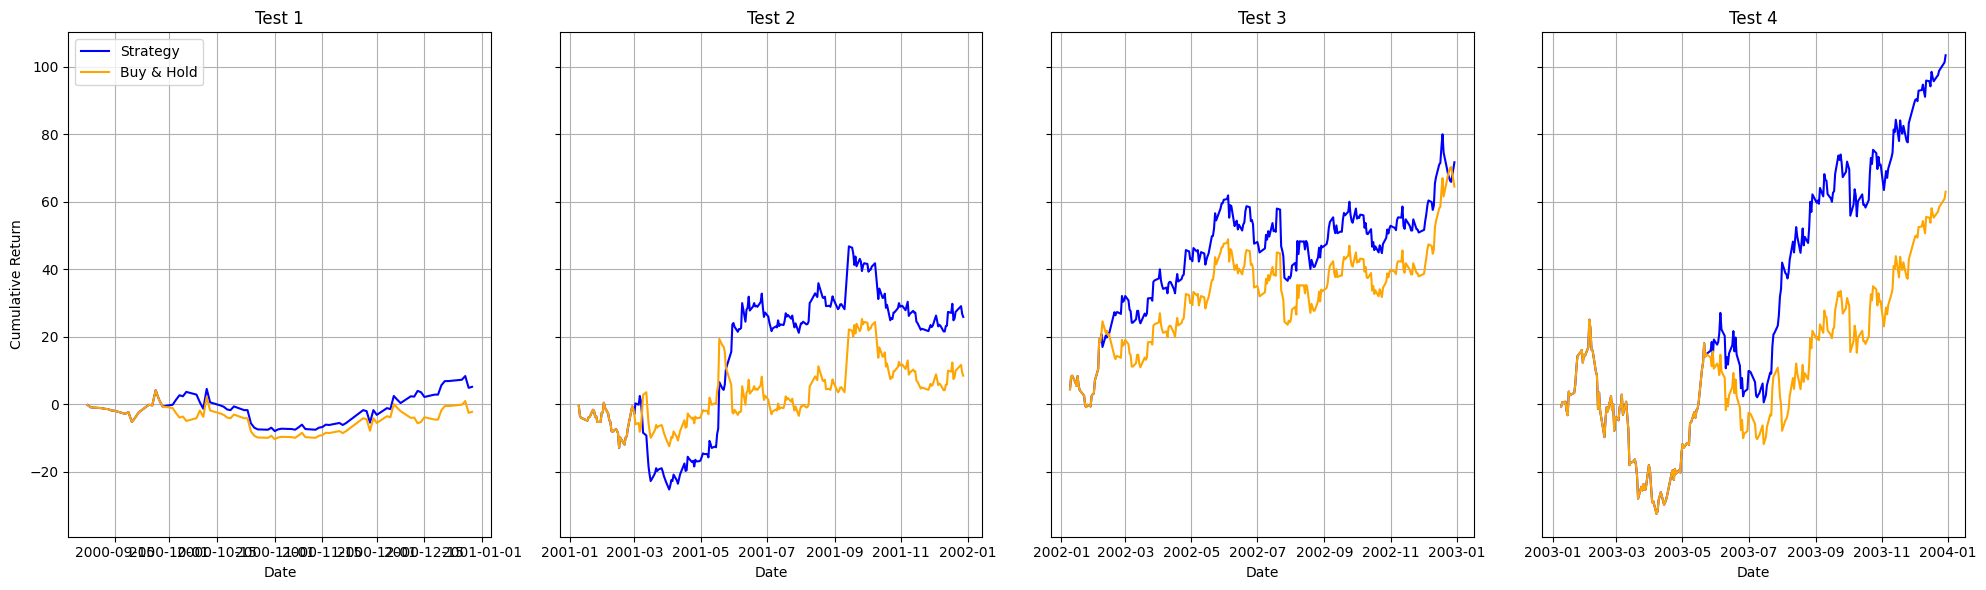

In [92]:
# Backtest results for each Bull Market Period
test1 = backtest_strategy('GC=F', '2000-01-01', '2000-12-31', 'Test 1')
test2 = backtest_strategy('GC=F', '2001-01-01', '2001-12-31', 'Test 2')
test3 = backtest_strategy('GC=F', '2002-01-01', '2002-12-31', 'Test 3')
test4 = backtest_strategy('GC=F', '2003-01-01', '2003-12-31', 'Test 4')

# Arrange plots side by side
dataframes = [test1, test2, test3, test4]
titles = [
    'Test 1',
    'Test 2',
    'Test 3',
    'Test 4'
]
plot_multiple_results(dataframes, titles)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


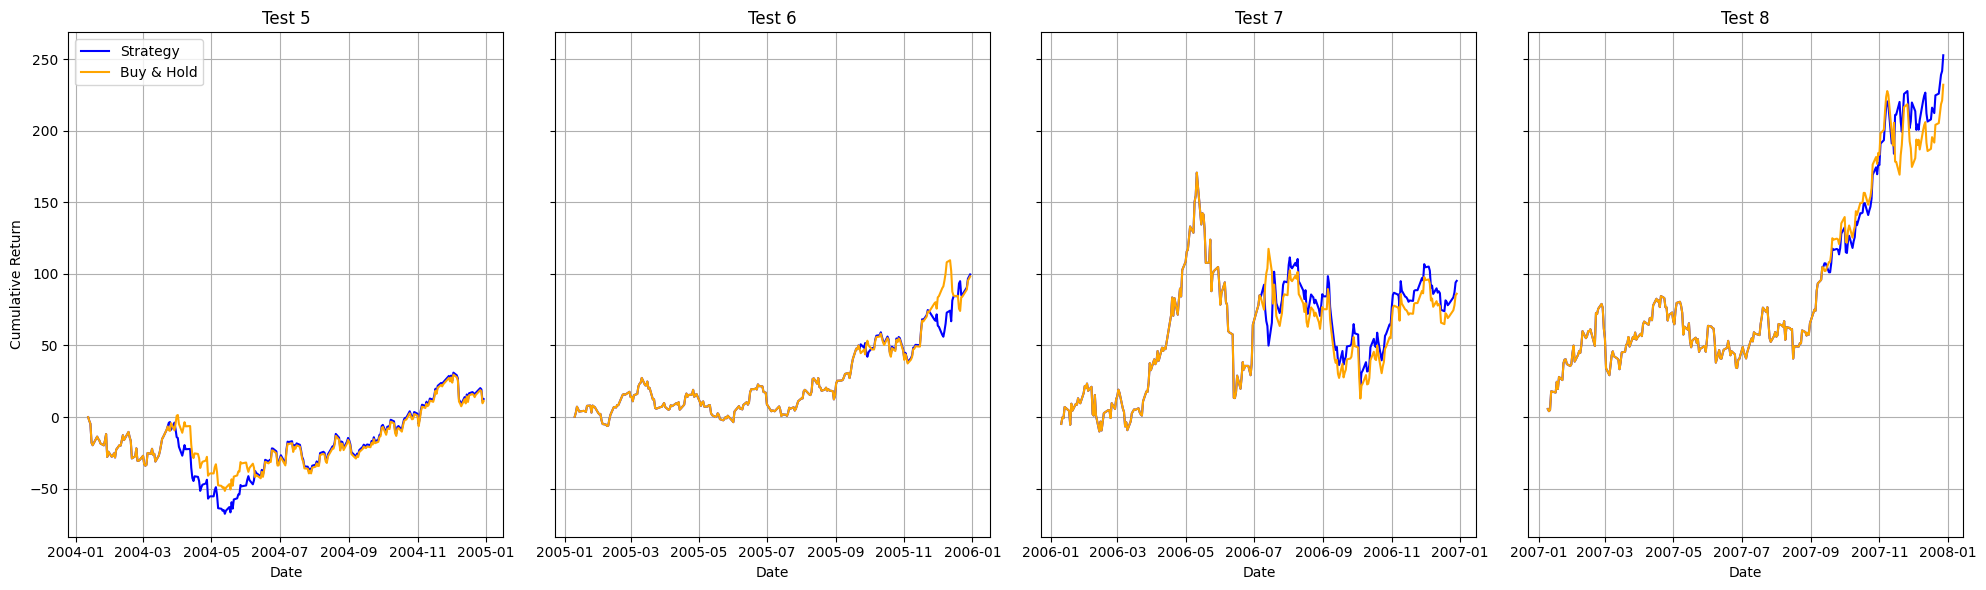

In [94]:
# Backtest results for additional Bull Market Periods
test5 = backtest_strategy('GC=F', '2004-01-01', '2004-12-31', 'Test 5')
test6 = backtest_strategy('GC=F', '2005-01-01', '2005-12-31', 'Test 6')
test7 = backtest_strategy('GC=F', '2006-01-01', '2006-12-31', 'Test 7')
test8 = backtest_strategy('GC=F', '2007-01-01', '2007-12-31', 'Test 8')

# Arrange plots side by side
dataframes = [test5, test6, test7, test8]
titles = [
    'Test 5',
    'Test 6',
    'Test 7',
    'Test 8'
]
plot_multiple_results(dataframes, titles)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


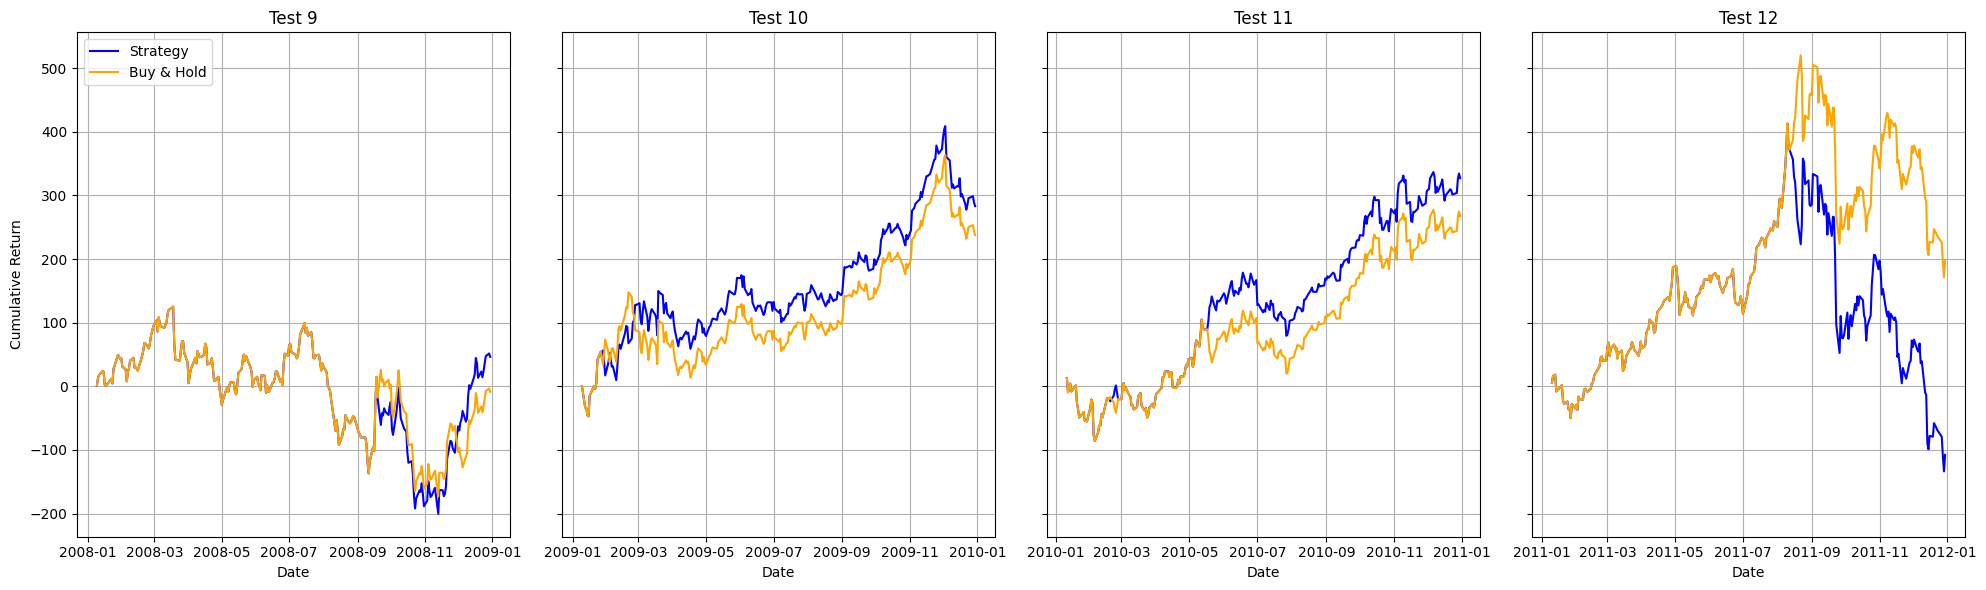

In [98]:
# Backtest results for Bull Market Periods (Test 9–12)
test9 = backtest_strategy('GC=F', '2008-01-01', '2008-12-31', 'Test 9')
test10 = backtest_strategy('GC=F', '2009-01-01', '2009-12-31', 'Test 10')
test11 = backtest_strategy('GC=F', '2010-01-01', '2010-12-31', 'Test 11')
test12 = backtest_strategy('GC=F', '2011-01-01', '2011-12-31', 'Test 12')

# Arrange plots side by side
dataframes = [test9, test10, test11, test12]
titles = [
    'Test 9',
    'Test 10',
    'Test 11',
    'Test 12'
]
plot_multiple_results(dataframes, titles)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


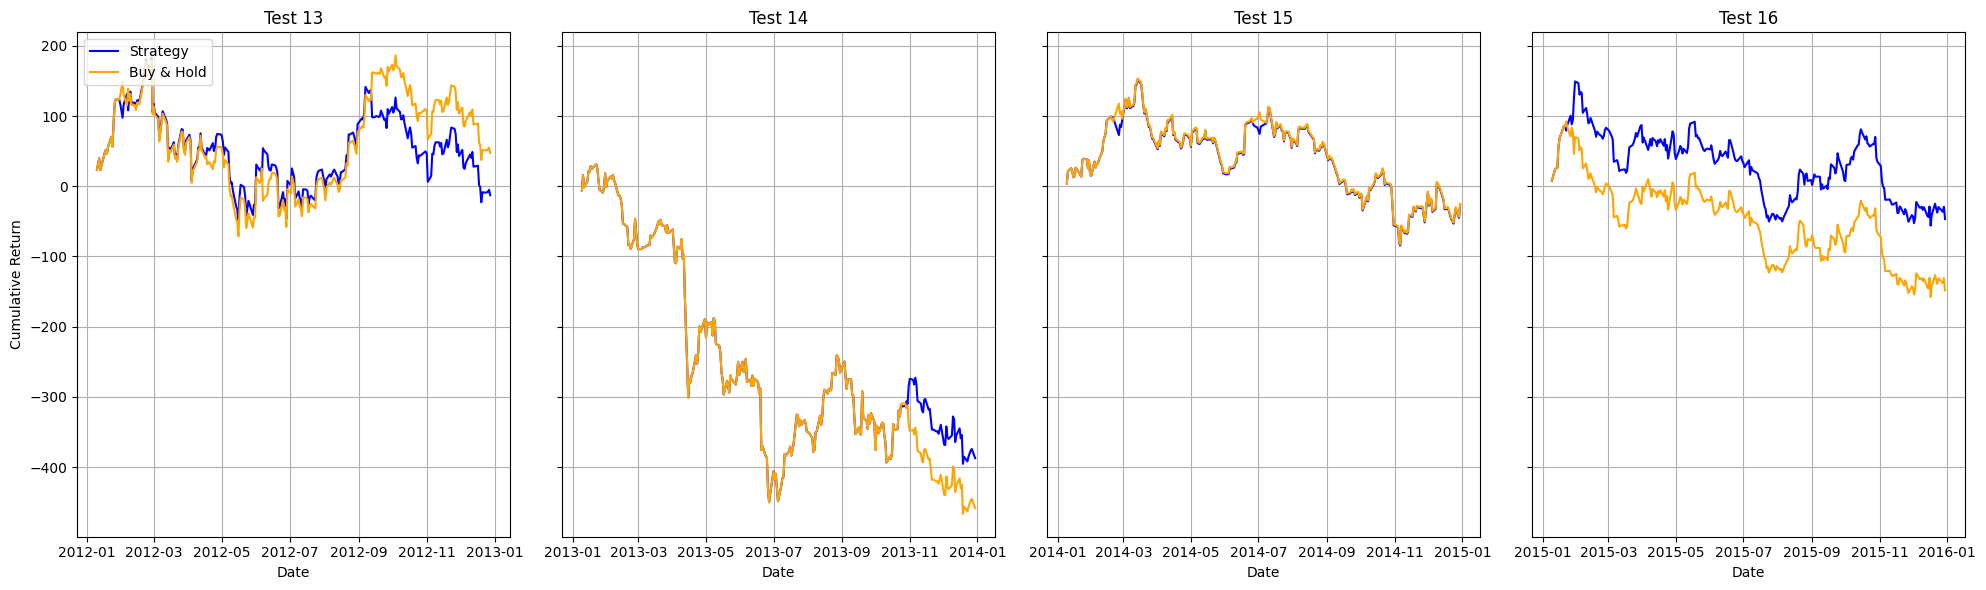

In [100]:
# Backtest results for Bull Market Periods (Test 13–16)
test13 = backtest_strategy('GC=F', '2012-01-01', '2012-12-31', 'Test 13')
test14 = backtest_strategy('GC=F', '2013-01-01', '2013-12-31', 'Test 14')
test15 = backtest_strategy('GC=F', '2014-01-01', '2014-12-31', 'Test 15')
test16 = backtest_strategy('GC=F', '2015-01-01', '2015-12-31', 'Test 16')

# Arrange plots side by side
dataframes = [test13, test14, test15, test16]
titles = [
    'Test 13',
    'Test 14',
    'Test 15',
    'Test 16'
]
plot_multiple_results(dataframes, titles)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


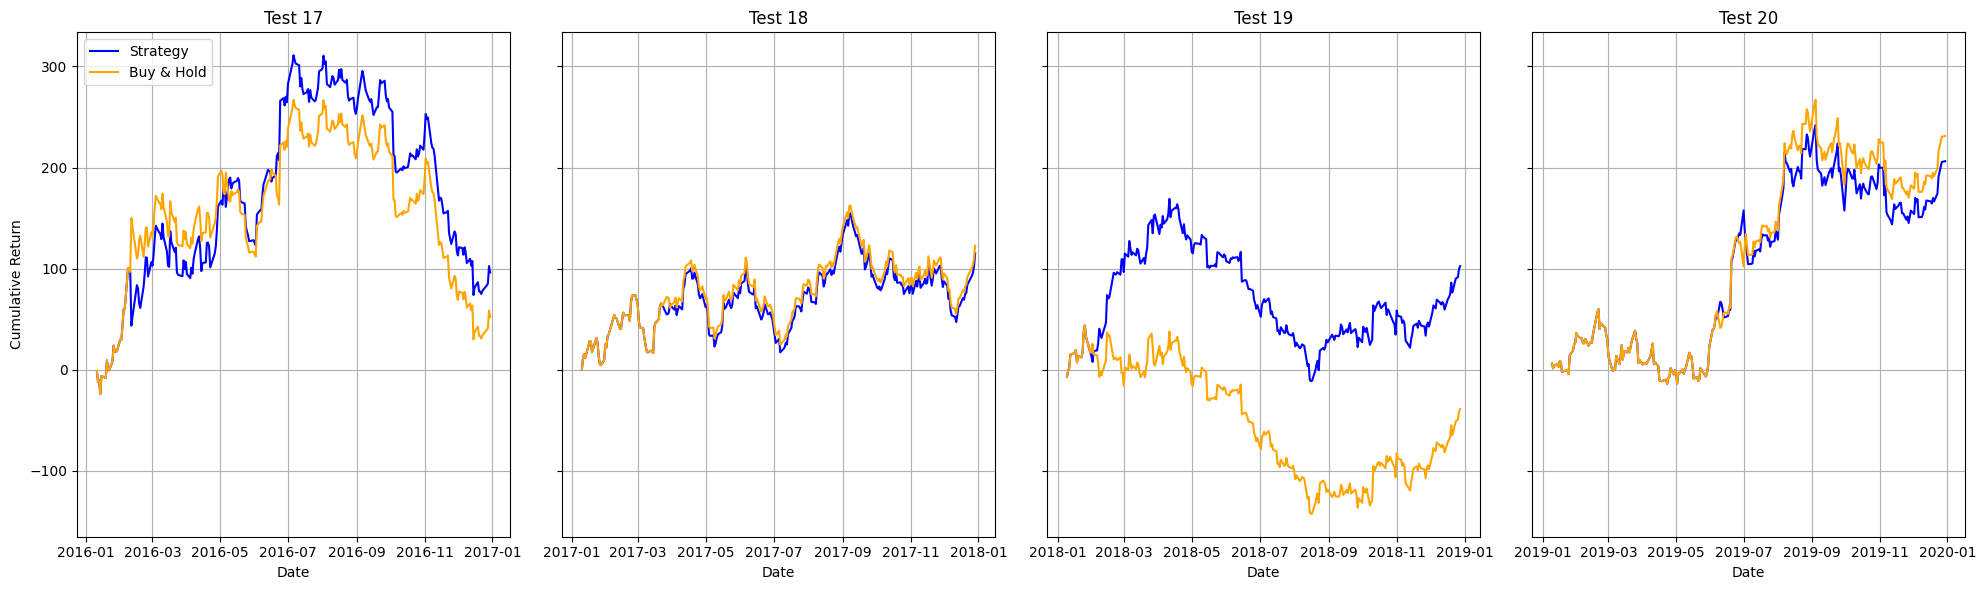

In [102]:
# Backtest results for Bull Market Periods (Test 17–20)
test17 = backtest_strategy('GC=F', '2016-01-01', '2016-12-31', 'Test 17')
test18 = backtest_strategy('GC=F', '2017-01-01', '2017-12-31', 'Test 18')
test19 = backtest_strategy('GC=F', '2018-01-01', '2018-12-31', 'Test 19')
test20 = backtest_strategy('GC=F', '2019-01-01', '2019-12-31', 'Test 20')

# Arrange plots side by side
dataframes = [test17, test18, test19, test20]
titles = [
    'Test 17',
    'Test 18',
    'Test 19',
    'Test 20'
]
plot_multiple_results(dataframes, titles)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


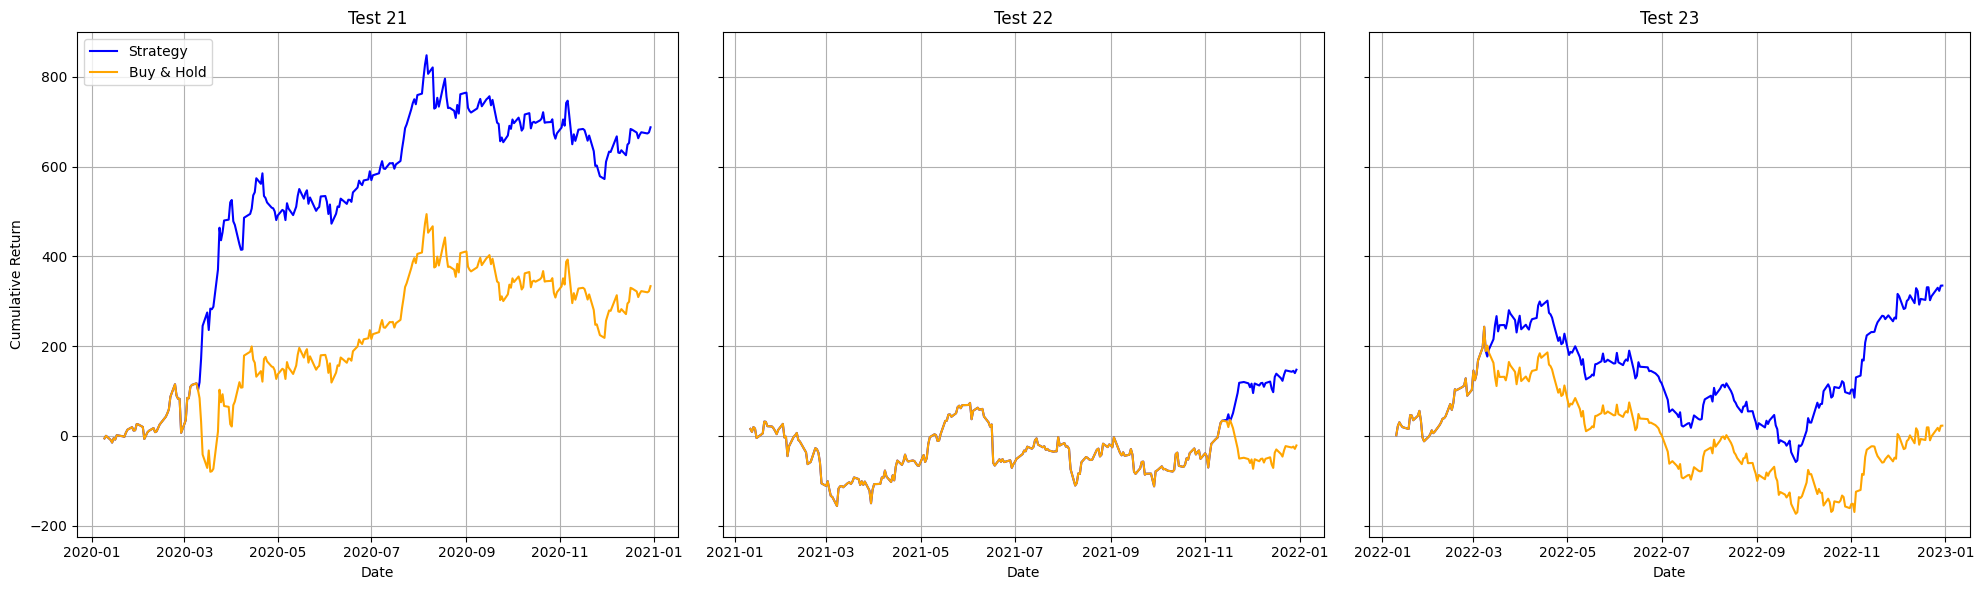

In [108]:
# Backtest results for Bull Market Periods (Test 21–23)
test21 = backtest_strategy('GC=F', '2020-01-01', '2020-12-31', 'Test 21')
test22 = backtest_strategy('GC=F', '2021-01-01', '2021-12-31', 'Test 22')
test23 = backtest_strategy('GC=F', '2022-01-01', '2022-12-31', 'Test 23')

# Arrange plots side by side
dataframes = [test21, test22, test23]
titles = [
    'Test 21',
    'Test 22',
    'Test 23'
]
plot_multiple_results(dataframes, titles)

## Analysis and Inference

Based on backtesting across 23 test cases, each representing a full year from 2000 to 2022, **the strategy outperformed the buy-and-hold approach in 18 out of 23 cases**, with around 7 of those showing significantly higher profits. **The strategy performs well in stable bull and neutral market conditions**, **but fails in bear market scenarios and during periods of high volatility**, where it incurs losses. To mitigate risk, **we recommend implementing stop-loss and take-profit conditions.** This analysis does not consider the potential improvement of incorporating additional indicators, such as the Exponential Moving Average (EMA) or Relative Strength Index (RSI), which could enhance decision-making.